# Explainatory Data Analysis

In [26]:
# Import relevant libraries
import dask.dataframe as dd
from dask.distributed import Client

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [27]:
# Set up a dask cluster
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34437,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:33547,Total threads: 2
Dashboard: http://127.0.0.1:41007/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:33561,


In [35]:
# Read in dataset
df = dd.read_parquet("../data/1_PREPARED/parking_ticket_2022.parquet")
df.head(5)

,summons_number,plate_id,registration_state,plate_type,violation_code,vehicle_body_type,vehicle_make,issuing_agency,street_code1,street_code2,...,unregistered_vehicle,vehicle_year,meter_number,feet_from_curb,violation_post_code,violation_description,no_standing_or_stopping,hydrant_violation,double_parking_violation,datetime
0,1457617912,JEB5683,NY,PAS,40,VAN,FORD,P,63430,69230,...,0,2007,-,3,NaN,NaN,NaN,NaN,NaN,2021-06-25 01:30:00
1,1457617924,JAN2986,NY,PAS,20,SUBN,DODGE,P,13490,40404,...,0,2007,-,0,NaN,NaN,NaN,NaN,NaN,2021-06-25 02:25:00
2,1457622427,FJH6630,TX,PAS,98,SDN,AUDI,P,79430,47130,...,0,0,-,0,NaN,NaN,NaN,NaN,NaN,2021-06-17 20:09:00
3,1457638629,RD1Y5N,MO,PAS,98,SDN,TOYOT,P,53130,23230,...,0,2001,-,0,NaN,NaN,NaN,NaN,NaN,2021-06-16 18:05:00
4,1457639580,T503814C,NY,OMT,40,TAXI,HONDA,P,81030,23930,...,0,2020,-,0,NaN,NaN,NaN,NaN,NaN,2021-07-04 22:58:00


In [3]:
df.columns

Index(['summons_number', 'plate_id', 'registration_state', 'plate_type',
       'violation_code', 'vehicle_body_type', 'vehicle_make', 'issuing_agency',
       'street_code1', 'street_code2', 'street_code3',
       'vehicle_expiration_date', 'violation_location', 'violation_precinct',
       'issuer_precinct', 'issuer_code', 'issuer_command', 'issuer_squad',
       'time_first_observed', 'violation_county', 'violation_in_front_of_or',
       'house_number', 'street_name', 'intersecting_street',
       'date_first_observed', 'law_section', 'sub_division',
       'violation_legal_code', 'days_parking_in_effect',
       'from_hours_in_effect', 'to_hours_in_effect', 'vehicle_color',
       'unregistered_vehicle', 'vehicle_year', 'meter_number',
       'feet_from_curb', 'violation_post_code', 'violation_description',
       'no_standing_or_stopping', 'hydrant_violation',
       'double_parking_violation', 'datetime'],
      dtype='object')

In [16]:
df[df['datetime'] > dt.datetime.now()].compute()

,summons_number,plate_id,registration_state,plate_type,violation_code,vehicle_body_type,vehicle_make,issuing_agency,street_code1,street_code2,...,unregistered_vehicle,vehicle_year,meter_number,feet_from_curb,violation_post_code,violation_description,no_standing_or_stopping,hydrant_violation,double_parking_violation,datetime


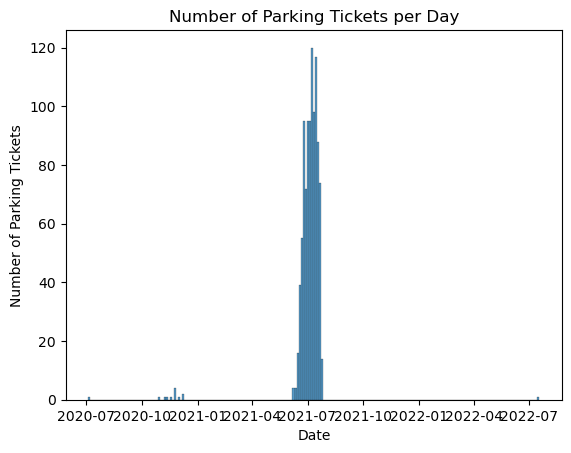

In [29]:
## Total Number of parking tickets per day
ax = sns.histplot(data=df, x='datetime')

ax.set_title('Number of Parking Tickets per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Parking Tickets')

plt.show()

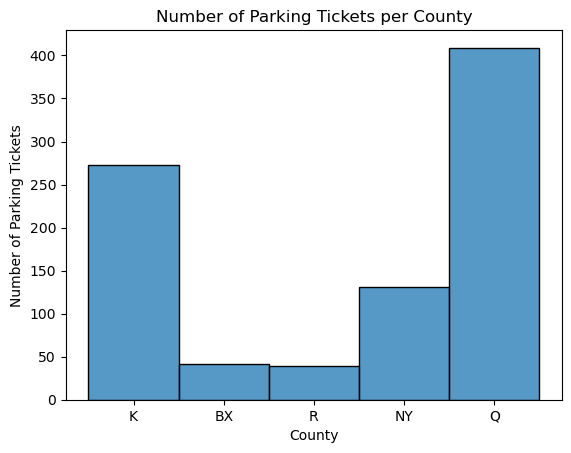

In [30]:
## Total Number of parking tickets per district
ax = sns.histplot(data=df, x='violation_county')

ax.set_title('Number of Parking Tickets per County')
ax.set_xlabel('County')
ax.set_ylabel('Number of Parking Tickets')

plt.show()

In [31]:
# Streets with the most parking violations
top_streets = df[['summons_number','street_name']].groupby(['street_name']).count().sort_values(by='summons_number',ascending=False).compute()
top_streets.head(10)

,summons_number
street_name,
BELLA ABZUG PARK,16
HUDSON BLVD WEST,13
HUDSON RIVER PARK,11
ASTORIA BLVD,11
SCHERMERHORN,10
37 AVE,10
SCHERMERHORN ST,8
BROADWAY,7
CENTRE STREET,7


In [39]:
# Car with most violations

top_streets = df[['summons_number','plate_id']].groupby(['plate_id']).count().sort_values(by='summons_number',ascending=False).compute()
top_streets.head(10)

,summons_number
plate_id,
BLANKPLATE,25
RB98105,4
639394,3
36BG19,3
80BF50,2
TN01926,2
KJX6112,2
HMV5456,2
JFE3602,2


In [40]:
# Car manufacture
top_streets = df[['summons_number','vehicle_make']].groupby(['vehicle_make']).count().sort_values(by='summons_number',ascending=False).compute()
top_streets.head(10)

,summons_number
vehicle_make,
TOYOT,124
HONDA,112
NISSA,95
FORD,92
CHEVR,60
ME/BE,46
DODGE,46
BMW,44
JEEP,35


In [42]:
## Total Number of parking tickets depending on the weather
df_weather = dd.read_parquet("../data/0_RAW/weather_2022.parquet")
df_weather.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2022-01-01 00:00:00,8.9,8.4,97.0,0.0,NaN,192.0,7.6,NaN,1014.4,NaN,4.0
2022-01-01 01:00:00,8.6,8.3,98.0,0.0,NaN,205.0,12.6,NaN,1014.0,NaN,4.0
2022-01-01 02:00:00,8.6,8.1,97.0,0.0,NaN,202.0,11.5,NaN,1013.6,NaN,5.0
2022-01-01 03:00:00,8.0,7.7,98.0,0.0,NaN,200.0,10.4,NaN,1013.7,NaN,4.0
2022-01-01 04:00:00,7.7,7.4,98.0,0.0,NaN,205.0,8.6,NaN,1013.6,NaN,4.0


In [52]:
df_weather.coco.isna().sum().compute()

232

<Axes: xlabel='coco', ylabel='Count'>

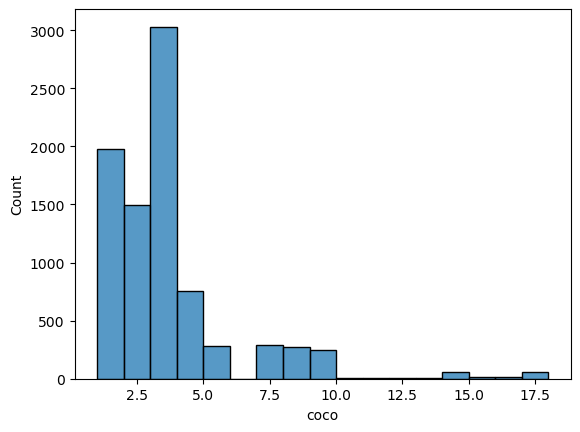

In [55]:
sns.histplot(x=df_weather['coco'], binwidth=1, bins=27)

In [50]:
df_weather.groupby('coco').count().sort_values(by='temp', ascending=False).compute()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun
coco,,,,,,,,,,
3.0,3030,3030,3030,3030,0,3030,3030,0,3030,0
1.0,1977,1977,1977,1977,0,1977,1977,0,1977,0
2.0,1499,1499,1499,1499,0,1499,1499,0,1499,0
4.0,753,753,753,753,0,753,753,0,753,0
7.0,286,286,286,286,0,286,286,0,286,0
5.0,282,282,282,282,0,282,282,0,282,0
8.0,271,271,271,271,0,271,271,0,271,0
9.0,248,248,248,248,0,248,248,0,248,0
14.0,54,54,54,54,0,54,54,0,54,0


In [6]:
## Total Number of parking tickets distant to schools

## Total Number of parking tickets distant to businesses

## Total Number of parking tickets distant to tourist attractions